# Machine Learning Assignment: Regression Task

### Import Library

In [1]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'whitegrid', color_codes = True)

from scipy.optimize import brute

from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.tools import add_constant

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, normalize, scale, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# คำอธิบายโดยรวมในการทำ Task2
จะพยายามแบ่งการทำ Model เป็น 3 model ใหญ่ๆคือ ARIMA, Regression และ Dynamic Regression โดย <br>
Dynamic Regression คือการนำ Error Term ของ ARIMA Model มาใช้กับ Regression Model

## Data Import

เลือกใช้ data จากภายนอกเพราะว่าต้องการค่าที่เป็นเวลาที่จริงขึ้น และสามารถนำข้อมูลอื่นๆ มาใช้ในการ Analysis และใช้ในการสร้าง model ชนิดอื่นด้วยโดย data ที่ได้เป็น data ที่ได้มาจากการ query ใน google bigquery โดยเลือกใช้ประเทศเป็น UK

In [2]:
df = pd.read_csv('UK_results-20200503-150942.csv') # from bigquery-public-data.covid19_ecdc.covid_19_geographic_distribution_worldwide

#### Split data into train and test

In [3]:
# df_res is train data
# use a bit more than 4/5 data to train and 1/5 to test
df_res = df[:109] # First 18
# df_test is test data
df_test = df[109:].reset_index(drop = True)

In [4]:
df_test.tail(2)

,date,day,month,year,daily_confirmed_cases,daily_deaths,confirmed_cases,deaths,countries_and_territories,geo_id,country_territory_code,pop_data_2018
17,2020-05-05,5,5,2020,3985,288,190584,28734,United_Kingdom,UK,GBR,66488991
18,2020-05-06,6,5,2020,4406,693,194990,29427,United_Kingdom,UK,GBR,66488991


In [5]:
# Safety first
df_res2 = df_res.copy()
df_test2 = df_test.copy()

# 1. ARIMA Model
เนื่องจาก ARIMA Model เป็น model ที่เป็น time series เลยจะใช้แค่ df_res ก่อนแล้วมาดู correlation ในตัว data อีกที

In [84]:
df_res = df_res2.copy()

In [85]:
# Set date column into index
df_res = df_res.set_index(['date'])
df_res.index = pd.to_datetime(df_res.index)

In [86]:
# slice dataframe because we use time series model so it only need 1 columns (of independent variables)
df_res = df_res.iloc[:, 3]
df_res.head(3)

date
2019-12-31    0
2020-01-01    0
2020-01-02    0
Name: daily_confirmed_cases, dtype: int64

In [87]:
df_res.tail()

date
2020-04-13    5288
2020-04-14    4342
2020-04-15    5252
2020-04-16    4603
2020-04-17    4617
Name: daily_confirmed_cases, dtype: int64

Text(0, 0.5, 'Amount')

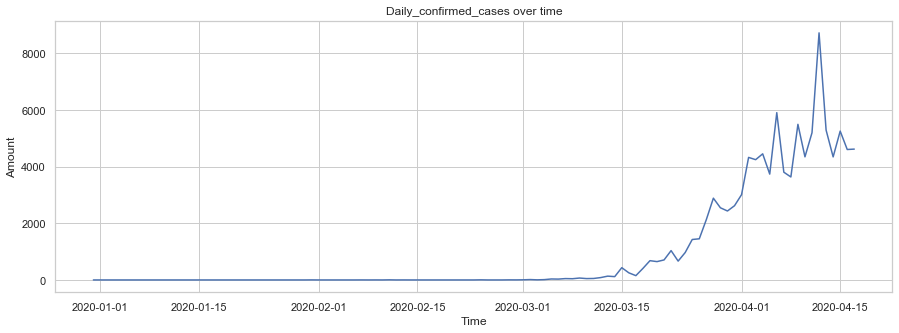

In [88]:
# Observed Daily confirmed Cases
plt.figure(figsize=(15, 5))
plt.plot(df_res)
plt.title('Daily_confirmed_cases over time')
plt.xlabel('Time')
plt.ylabel('Amount')

<hr>

ดู Autocorrelation ใน daily change ในแต่ละวัน

In [89]:
daily_diff = df_res.diff()
daily_diff = daily_diff.dropna()
# Compute autocorrelation of daily different of confirmed cases
autocorr_daily = daily_diff.autocorr()
print("The autocorrelation of daily confirmed cases\
 is %4.2f" %(autocorr_daily))

The autocorrelation of daily confirmed cases is -0.36


ค่อนข้างส่งผลต่อค่าในวันถัดๆไป แต่ยังไงก็ต้องมาดู Autocorrelation function ว่า lags เก่าๆ(ค่าวันเก่า)มีผลทางตรงและทางอ้อมต่อวันต่อๆไปยังไงบ้าง

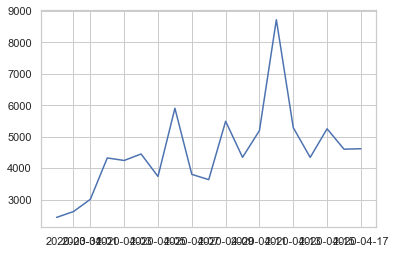

In [90]:
# plot to see if the confirmed cases is always up (check if it not cumulative)
plt.plot(df_res[90:])

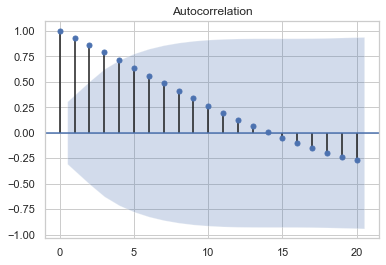

In [91]:
# define only 20 lags for plot and 95 % confidence interval
df_res_acf = acf(df_res)
plot_acf(df_res_acf, lags = 20, alpha = 0.05)
plt.show()

## Check if the data is Stationarity

ตรวจดูว่าข้อมูล Time Series ของเราเป็น Stationarity หรือเปล่า

In [92]:
result = adfuller(df_res)

print(f'ADF StatisticL {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF StatisticL -2.801956010528112
p-value: 0.05799490864094657
Critical Values:
	1%: -3.4996365338407074
	5%: -2.8918307730370025
	10%: -2.5829283377617176


สังเกตุที่ค่า p value หาก p value ที่ได้ > 0.05 หรือมากกว่าค่าความเชื่อมั่นที่ตั้งไว้ (95%) ก็จะถือว่าเป็นข้อมูลที่เป็น Non stationarity

เนื่องจากข้อมูลเป็น Non stationarity อาจจะทำให้การสร้าง ARIMA Model ทำนายออกมาได้ไม่ดี จึงลองใช้ differencing จากข้อมูลในสันก่อนหน้านี้ และนำมาทำ AR Model ก่อน

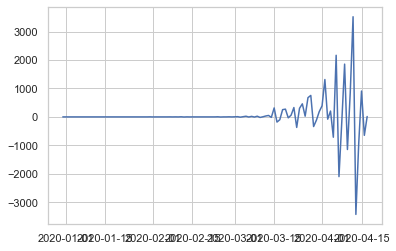

In [93]:
# Do AR Model and estimate order parameter
# First check if it still trend shape
daily_diff = df_res.diff(periods=1)
daily_diff = daily_diff.fillna(0)
plt.plot(daily_diff)

In [94]:
result = adfuller(daily_diff)

print(f'ADF StatisticL {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF StatisticL -2.8964122854889216
p-value: 0.045766793337651754
Critical Values:
	1%: -3.5011373281819504
	5%: -2.8924800524857854
	10%: -2.5832749307479226


จาก p-value จะเห้นได้ว่าข้อมูลกลายเป็น Stationarity แล้ว (p-value <= 0.05 จะถือว่าข้อมูลเป็นข้อมูลที่เป็น Stationarity)

#### AR Model
estimate order of model using Bayesian Information Criterion (BIC)

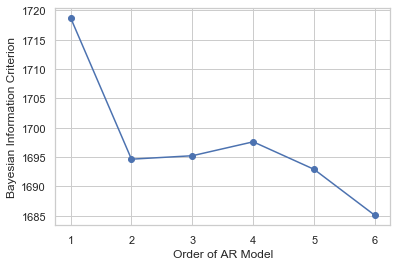

In [95]:
BIC = np.zeros(7)
for p in range(7):
    model = ARMA(daily_diff, order = (p, 0))
    result = model.fit()
    # Save BIC for each AR
    BIC[p] = result.bic

plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()
warnings.filterwarnings('ignore')

look like 6 order from BIC in AR Model is good enogh but if I used 6 as p order this will result in being not stationarity <br> I guess it because of overfitted so I will use 5 p orders as it just fitted not to overfit and you cant use in other model

#### MA Model
estimate order of MA Model using Autoregressive Function โดยใช้การประมาณจากการ plot autoregressive ก่อนหน้านี้

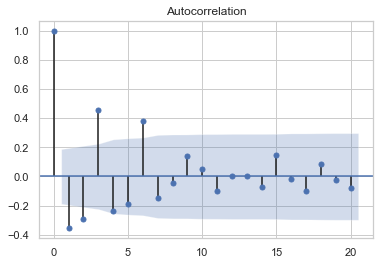

In [96]:
plot_acf(daily_diff, lags = 20)
plt.show()

มี lags ที่ทำงานได้ดีหรือเกิน signifint line อยู่ประมาณ 3 เลยจะ fix q order ไว้ที่ 3 ก่อน

# แต่ !
ถึงมันจะเป็น 3 แต่ก็ทำงานได้ดีสุดถ้า q-orderเป็น 4 เลยลอง plot ดู

In [97]:
model = ARMA(daily_diff, order=(0, 4))
result = model.fit()
print(result.summary())

                                ARMA Model Results                               
Dep. Variable:     daily_confirmed_cases   No. Observations:                  109
Model:                        ARMA(0, 4)   Log Likelihood                -839.728
Method:                          css-mle   S.D. of innovations            535.293
Date:                   Fri, 08 May 2020   AIC                           1691.456
Time:                           01:47:24   BIC                           1707.604
Sample:                       12-31-2019   HQIC                          1698.004
                            - 04-17-2020                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          44.7157     25.863      1.729      0.084      -5.974      95.405
ma.L1.daily_confirmed_cases    -0.4597      0.090     -5

In [98]:
print(result.params)

const                          44.715703
ma.L1.daily_confirmed_cases    -0.459694
ma.L2.daily_confirmed_cases    -0.170750
ma.L3.daily_confirmed_cases     0.266969
ma.L4.daily_confirmed_cases    -0.139265
dtype: float64


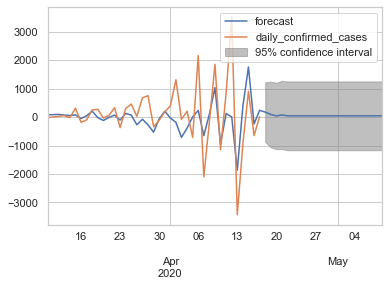

In [99]:
# Try forecast using MA Model
result.plot_predict(start = 70, end = 130)
plt.show()

# แต่ !
แต่ถึงกระนั้น q order ที่ดีและ fit พอเหมาะอยู่แล้วคือ 3 เพราะมันทำงานได้ดีมาแค่ 3 orders <br>เลยจะเลือก order ไว้แค่ 3 เท่านั้นสำหรับการนำไปทำ model ARMA และ ARIMA

### Lets do some ARMA model

ผลการทดลองเก่าๆ<br>
(4, 5) 1797 <br>
(10, 2) 1785 <br>
(11, 1) 1783 <br>
(11, 2) 1781 <br>
(12, 2) 1782 <br>
(12, 3) 1784

In [116]:
mod_arma1 = ARMA(daily_diff, order = (5, 3))
res_arma1 = mod_arma1.fit()
print(f'The AIC for an AR order (5, 3) is : {res_arma1.aic}')

The AIC for an AR order (5, 3) is : 1660.241548380165


In [124]:
por = 5
qor = 2
mod_arma1 = ARMA(daily_diff, order = (por, qor))
res_arma1 = mod_arma1.fit()
print(f'The AIC for an AR order ({por}, {qor}) is : {res_arma1.aic}')

The AIC for an AR order (5, 2) is : 1663.295849848554


### ARIMA RESULT

In [101]:
df_res = df_res.fillna(0)

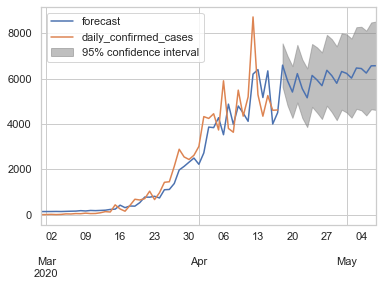

In [136]:
model_ari = ARIMA(df_res, order = (5, 1, 0))
res_ari = model_ari.fit()

res_ari.plot_predict(start = 60, end = 128)
plt.show()

In [137]:
print(res_ari.summary())

                                ARIMA Model Results                                
Dep. Variable:     D.daily_confirmed_cases   No. Observations:                  108
Model:                      ARIMA(5, 1, 0)   Log Likelihood                -822.895
Method:                            css-mle   S.D. of innovations            488.892
Date:                     Fri, 08 May 2020   AIC                           1659.789
Time:                             12:08:47   BIC                           1678.564
Sample:                         01-01-2020   HQIC                          1667.402
                              - 04-17-2020                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            51.5975     18.356      2.811      0.005      15.620      87.575
ar.L1.D.daily_confirmed_cases    -

Plot residual errors <br>
from: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

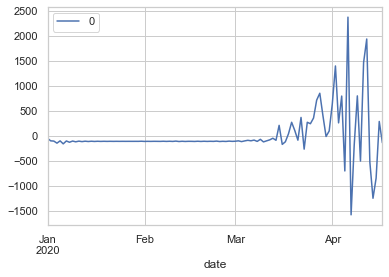

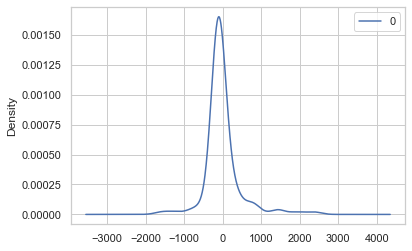

                 0
count   108.000000
mean     -4.081389
std     474.713477
min   -1580.406642
25%    -111.665839
50%    -109.231603
75%     -86.560137
max    2374.792332


In [104]:
residuals = pd.DataFrame(res_ari.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

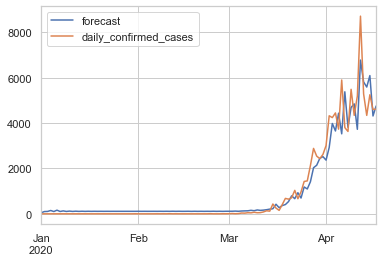

In [105]:
# Acutal vs fit
res_ari.plot_predict(dynamic=False)
plt.show()

<hr>

# 2. Regression model

ในการทำ Regression ได้เลือกใช้ข้อมูลที่มากกว่าเดิมโดยเป็นข้อมูล mobility ช่วงที่มีเหตุ Covid 19 เพราะข้อมูล mobility เป็นข้อมูลที่บ่งบอกเรื่องการเคลื่อนย้ายขนส่งหรือเดินทางได้เป็นอย่างดี จึงอาจมีส่วนช่วยในการทำนายค่าของคนที่เป็น COVID-19

In [106]:
df_mob = pd.read_csv('UK_mobility_results-20200503-152437.csv') # from bigquery-public-data.covid19_google_mobility.mobility_report

#### df_mob description 
This dataset aims to provide insights into what has changed in response to policies aimed at combating COVID-19. It reports movement trends over time by geography, across different categories of places such as retail and recreation, groceries and pharmacies, parks, transit stations, workplaces, and residential.

This dataset is intended to help remediate the impact of COVID-19. It shouldn’t be used for medical diagnostic, prognostic, or treatment purposes. It also isn’t intended to be used for guidance on personal travel plans. <br>
More at: https://www.google.com/covid19/mobility/data_documentation.html


### df_mob exploration

In [29]:
# Set index to date and change it to datetime
df_mob = df_mob.set_index(['date'])
df_mob.index = pd.to_datetime(df_mob.index)

In [30]:
df_mob.head(2)

,country_region_code,country_region,sub_region_1,sub_region_2,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,
2020-04-02,GB,United Kingdom,NaN,NaN,-75.0,-32.0,-24.0,-73.0,-70.0,29.0
2020-04-03,GB,United Kingdom,NaN,NaN,-76.0,-30.0,-25.0,-72.0,-69.0,29.0


Check to see when the data is started

In [31]:
# I will group by the date
df_mob2 = df_mob.groupby('date').mean()
df_mob2.head(2)

,sub_region_2,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,
2020-02-15,NaN,-11.309211,-5.743421,-36.874074,-12.534247,-3.892617,2.433628
2020-02-16,NaN,-5.979866,-4.516779,-24.661654,-6.248227,-2.594595,1.139535


In [32]:
df_res.head(2)

date
2019-12-31    0
2020-01-01    0
Name: daily_confirmed_cases, dtype: int64

เหมือนว่าช่วงเวลาของข้อมูลจะไม่ตรงกัน เลยอาจจะใช้แค่ข้อมูล df_res เพียงอย่างเดียว

#### Correlation between all variables

In [33]:
# Back in using old df_res
df_res = df_res2.copy()
df_res = df_res.set_index(['date'])
df_res.index = pd.to_datetime(df_res.index)
df_res = df_res.iloc[:, 3:7]

df_res_change = df_res.pct_change()
df_res_change
# At first there might be some 0 data row because there are not
# much infected appear

,daily_confirmed_cases,daily_deaths,confirmed_cases,deaths
date,,,,
2019-12-31,NaN,NaN,NaN,NaN
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN
...,...,...,...,...
2020-04-13,-0.393508,-0.182360,0.066944,0.059143
2020-04-14,-0.178896,0.084548,0.051519,0.060562
2020-04-15,0.209581,0.403226,0.059264,0.080129


เลือกใช้ที่เป็น percentage change เพราะใช้บอกความสัมพันธ์ระหว่างการเปลี่ยนแปลงได้ดีกว่าแบบปกติ

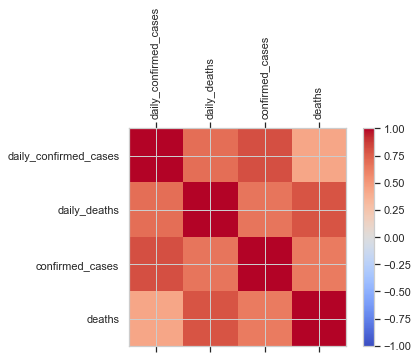

In [34]:
corr = df_res_change.corr()
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(corr, cmap = 'coolwarm', vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, len(df_res_change.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation = 90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_res_change.columns)
ax.set_yticklabels(df_res_change.columns)
plt.show()
# https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3

เหมือนว่าจะมีความสัมพันธ์เป็นไปในเชิงบวกเยอะ งั้นเดี๋ยวลองทำ scatter plot ดู

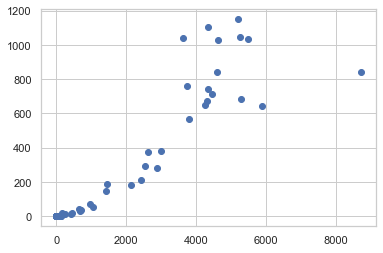

In [35]:
plt.scatter(df_res.daily_confirmed_cases, df_res.daily_deaths)

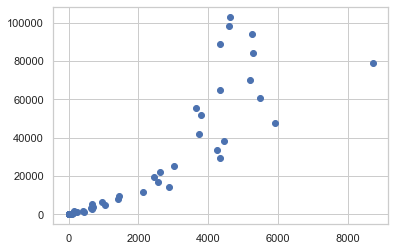

In [36]:
plt.scatter(df_res.daily_confirmed_cases, df_res.confirmed_cases)

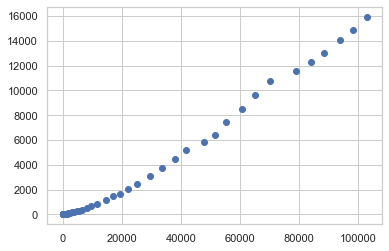

In [37]:
plt.scatter(df_res.confirmed_cases, df_res.deaths)

มีความสัมพันธ์กันในเชิงบวกเป็นจำนวนมาก จึงลองทำ LinearRegression ดูแบบคร่าวๆก่อน

### Regression Model 1

Define features building funtion becuase I split data into two set up there (ARIMA Model) so it will be messy if im not defining new function to create feature itself

#### Here is original data columns <br>
['date', 'day', 'month', 'year', 'daily_confirmed_cases', 'daily_deaths',
       'confirmed_cases', 'deaths', 'countries_and_territories', 'geo_id',
       'country_territory_code', 'pop_data_2018']

### Feature Engineering

ตรงการสร้าง features นี้จะลบ featuresที่เป็น confirmed cases และ daily confirmed cases ไปด้วยเพราะโกงไป
- อธิบายการทำงานคร่าวๆคือจะลบตัวแปรที่ไม่จำเป็นออกไป สร้างตัวแปร interval ขึ้นมาแทน date สร้างตัวแปร t-1 และ t-2 <br>
เพื่อนำค่า daily_confirmed_cases ของวันก่อนหน้า 1 วันและ 2 วันไปใช้ และสร้าง dataframe ใหม่ <br>
เพื่อหาค่า percentage change ของค่าที่เปลี่ยนแปลงไปตามเวลา แล้วนำทั้งหมดมารวมกันและทำให้เป็น numpy array เพื่อให้ง่ายต่อการนำไปสร้างแบบจำลอง

In [38]:
def add_feat(df):
    
    df.date = pd.to_datetime(df.date)
    df['inter_t'] = df.date.apply(lambda x: x.toordinal())
        
    # back at normal features
    c_cases = df.daily_confirmed_cases.values
    n_list = ['t-1', 't-2']
    df2 = df
    #df2 = 
    df2 = df2.drop(np.arange(2)).reset_index(drop = True)
    for i in range(2)[::-1]:
        df2[n_list[-i + 1]] = c_cases[i: i - 2]
        
    #for percentage change part
    df_change = df2.iloc[:, [0, 5, 7, 9, 10]]
    df_change = df_change.set_index(['date'])
    df_change = df_change.pct_change()
    df_change = df_change.fillna(0)
    
    df2 = df2.drop(columns = ['date', 'daily_confirmed_cases', 'confirmed_cases'])
    ser1 = np.array(df2.values)
    ser2 = np.array(df_change.values)
    ser3 = np.hstack((ser1, ser2))
    return ser3

In [39]:
# Retrieve data
df_res = df_res2.copy()
df_res = df_res.iloc[:, :8]

df_test = df_test2.copy()
df_test = df_test.iloc[:, :8]

Now I need to write function to retrive label data and store it in y variables

In [40]:
def label_y(df):
    df = df.drop(np.arange(2)).reset_index(drop = True)
    y = df.iloc[:, 4].values
    return y.reshape((-1, 1))

In [41]:
df_test[:5]

,date,day,month,year,daily_confirmed_cases,daily_deaths,confirmed_cases,deaths
0,2020-04-18,18,4,2020,5599,935,108692,16879
1,2020-04-19,19,4,2020,5525,1115,114217,17994
2,2020-04-20,20,4,2020,5850,498,120067,18492
3,2020-04-21,21,4,2020,4676,559,124743,19051
4,2020-04-22,22,4,2020,4301,1172,129044,20223


### Data Preparation

In [42]:
X_train = add_feat(df_res)
X_test = add_feat(df_test)
y_train = label_y(df_res)
y_test = label_y(df_test)

#### Shape print

In [43]:
print(X_train.shape, X_test.shape)

(107, 12) (17, 12)


In [44]:
print(y_train.shape, y_test.shape)

(107, 1) (17, 1)


Check if there is still NaN or Inf value before input data into training

In [45]:
np.isinf(X_train).any()

True

In [46]:
ar_inf = np.where(np.isinf(X_train))
print(ar_inf)

(array([30, 31, 37, 38, 39, 40, 41, 42, 43, 44, 54, 55, 58, 59, 65, 65, 68,
       71], dtype=int64), array([10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11,  8,  9,  8,
        8], dtype=int64))


In [47]:
# set them to zero
X_train[X_train == np.inf] = 0

In [48]:
np.isinf(X_train).any()

False

In [49]:
X_train.shape

(107, 12)

### Modeling

In [50]:
model = LinearRegression().fit(X_train, y_train)
y_pred1 = model.predict(X_test)

In [51]:
mae1 = mean_absolute_error(y_test, y_pred1)
print(mae1)

884.800071384977


เนื่องจากต้องการ metrics ที่เหมาะสมในการทำนายมากกว่านี้ (MAPE, RMSE) จึงขอเขียน function MAPE และ RMSE <br>
https://www.statisticshowto.com/mean-absolute-percentage-error-mape/

In [52]:
def MAPE(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

In [53]:
mape1 = MAPE(y_test, y_pred1)
print(mape1)

18.1960203733609


In [146]:
mean_absolute_error(y_test, y_pred1)

884.800071384977

In [138]:
RMSE(y_test, y_pred1)

265.25665082538995

มี day MAPE = 66, ไม่มี = 69

In [54]:
def RMSE(y, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    m = len(y)
    return np.sqrt(mse/m)

เพราะจากการทำ feature engineering data เลยถูกลบออกไป 2 rows

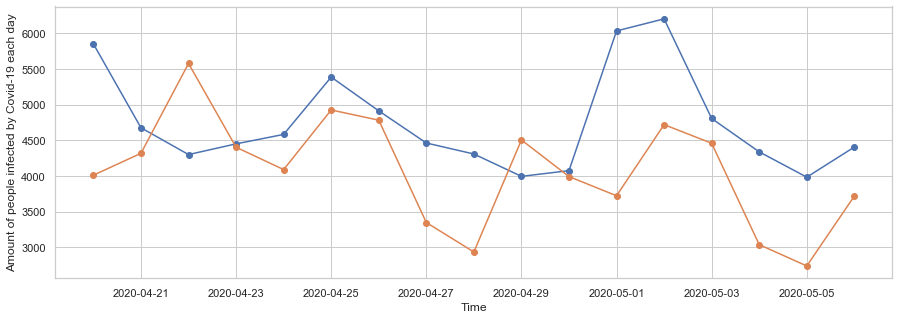

In [55]:
plt.figure(figsize = (15, 5))
plt.plot(df_test.drop(np.arange(2)).date, y_test, marker = 'o')
plt.plot(df_test.drop(np.arange(2)).date, y_pred1, marker = 'o')
plt.xlabel('Time')
plt.ylabel('Amount of people infected by Covid-19 each day')
plt.show()

### Polynomial 2 degrees

In [56]:
# re-arange data
X_train = add_feat(df_res)
X_test = add_feat(df_test)
y_train = label_y(df_res)
y_test = label_y(df_test)

# set inf value to zero
X_train[X_train == np.inf] = 0

In [57]:
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X_train)
model = LinearRegression().fit(X_poly, y_train)

pred = model.predict(poly.transform(X_test))

In [143]:
X_poly.shape

(107, 91)

In [141]:
y_train.shape

(107, 1)

In [59]:
y_test[:5]

array([[5850],
       [4676],
       [4301],
       [4451],
       [4583]], dtype=int64)

In [60]:
pred[:5]

array([[4535866.78027344],
       [3098372.07617188],
       [ -87217.14160156],
       [2804469.140625  ],
       [2567741.70117188]])

In [61]:
MAPE(y_test, pred)

307004.9351299722

In [140]:
RMSE(y_test, pred)

5049303.760523509

#### สรุปผลการทำ Polynomial Degree = 2 

ณ ตอนนี้ไม่ควรทำ Polynomial เพราะว่าจะทำให้จำนวนของ sample data < features ที่ใช้ แล้วจะได้ผลที่มี error เยอะจึงไม่มีการทำ polynomial features ต่อ

### Regression Model 2

#### Standard Scaler

In [62]:
# train and test interval
# df_res = df[:109]

In [63]:
# re-arange data
X_train = add_feat(df_res)
X_test = add_feat(df_test)
y_train = label_y(df_res)
y_test = label_y(df_test)

# set inf value to zero
X_train[X_train == np.inf] = 0

In [64]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
model = LinearRegression().fit(X_train_norm, y_train)

X_test_norm = scaler.transform(X_test)

In [65]:
y_pred2 = model.predict(X_test_norm)

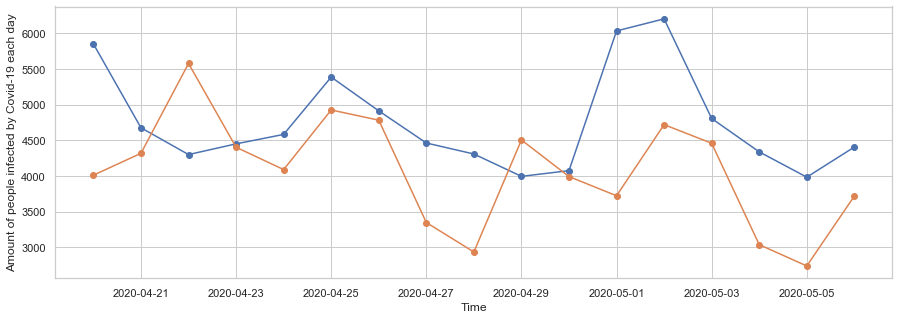

In [66]:
plt.figure(figsize = (15, 5))
plt.plot(df_test.drop(np.arange(2)).date, y_test, marker = 'o')
plt.plot(df_test.drop(np.arange(2)).date, y_pred2, marker = 'o')
plt.xlabel('Time')
plt.ylabel('Amount of people infected by Covid-19 each day')
plt.show()

In [67]:
mae2 = mean_absolute_error(y_test, y_pred2)
print(mae2)

884.8000713724954


In [68]:
mape2 = MAPE(y_test, y_pred2)
print(mape2)

18.196020373101625


In [144]:
RMSE(y_test, y_pred2)

265.2566508217678

#### Min-Max Scaler

In [69]:
X_train = add_feat(df_res)
X_test = add_feat(df_test)
y_train = label_y(df_res)
y_test = label_y(df_test)

# set inf value to zero
X_train[X_train == np.inf] = 0

In [70]:
min_max_scaler = MinMaxScaler()
X_train_norm2 = min_max_scaler.fit_transform(X_train)
model = LinearRegression().fit(X_train_norm2, y_train)

X_test_norm2 = scaler.transform(X_test)

In [71]:
y_pred3 = model.predict(X_test_norm2)

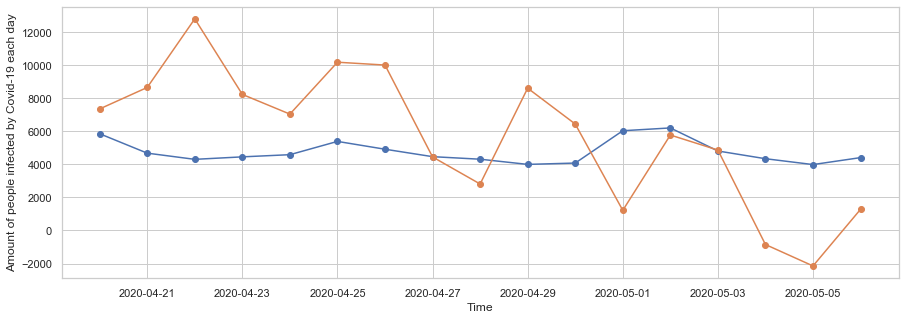

In [72]:
plt.figure(figsize = (15, 5))
plt.plot(df_test.drop(np.arange(2)).date, y_test, marker = 'o')
plt.plot(df_test.drop(np.arange(2)).date, y_pred3, marker = 'o')
plt.xlabel('Time')
plt.ylabel('Amount of people infected by Covid-19 each day')
plt.show()

In [73]:
mae3 = mean_absolute_error(y_test, y_pred3)
print(mae3)

3431.158870876118


In [74]:
mape3 = MAPE(y_test, y_pred3)
print(mape3)

75.30601426170954


In [148]:
RMSE(y_test, y_pred3)

995.2417545825414

### สรุปผล regresssion

ณ ตอนนี้ยังสรุปผลไม่ได้มากว่า Normalize หรือปรับ scale ต่างๆบนข้อมูลจะมีผลต่อผลลัพธ์จากการทำนายหรือไม่ เพราะข้อมูลในขณะนี้ มีน้อยมากๆ จึงวัดผลลัพธ์ที่แน่นอนจากการ test ได้ยาก "ได้แล้ววววว !!!"

<hr>

### Final Regression model used

In [75]:
X_train = add_feat(df_res)
X_test = add_feat(df_test)
y_train = label_y(df_res)
y_test = label_y(df_test)

# set inf value to zero
X_train[X_train == np.inf] = 0

In [76]:
X_train = add_constant(X_train)
X_test = add_constant(X_test)

In [77]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

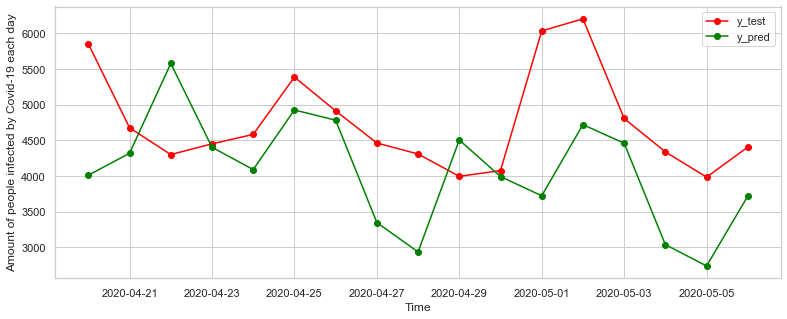

In [78]:
plt.figure(figsize = (13, 5))
plt.plot(df_test.drop(np.arange(2)).date, y_test, marker = 'o', color='red', label = 'y_test')
plt.plot(df_test.drop(np.arange(2)).date, y_pred, marker = 'o', color='green', label = 'y_pred')
plt.xlabel('Time')
plt.ylabel('Amount of people infected by Covid-19 each day')
plt.legend()
plt.show()

In [79]:
MAPE(y_test, y_pred)

18.1960203733609

<hr>

# 3. Dynamic Regression (Regression with ARIMA errors)

#### Extract Features parameteres

Regression features parameteres

In [80]:
model.intercept_

array([1.57817102e+08])

In [81]:
model.coef_

array([[ 2.18879931e+02,  6.64135671e+03, -2.17781349e-09,
         2.92189453e+00, -2.88278083e-02, -2.14020500e+02,
         4.54262519e-01,  2.58097675e-02,  5.44427450e+00,
        -7.80009449e+01, -1.15785010e+02, -1.76584882e+02]])

In [82]:
df_res.head(2)

,date,day,month,year,daily_confirmed_cases,daily_deaths,confirmed_cases,deaths,inter_t
0,2019-12-31,31,12,2019,0,0,0,0,737424
1,2020-01-01,1,1,2020,0,0,0,0,737425
